In [2]:
%reload_ext jupyter_black

We start by importing relevant libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union, Tuple, Iterable
from scipy.stats import gaussian_kde
import random, shutil, os, itertools, black, jupyter_black

# Data loading and preprocessing

In [6]:
def naive_csv_sampler(
    csv_path: str,
    sample_size: int,
    num_records: int | None = None,
    header: str | None = "infer",
) -> pd.DataFrame:
    """Read samples of rows from csv file

    Args:
        csv_path (str): Path to file including file extensions
        sample_size (int): Number of rows to sample
        num_records (int | NoneType, optional): Total records in file, defaults to None. If None, the file will be scanned (costly)
        header (str | NoneType, optional): 'header'-parameter for pandas, defaults to 'infer'. Set to None if file has no header.

    Returns:
        pd.DataFrame: Dataframe with sampled entries (and potentially header)
    """
    if num_records is None:
        num_records = newlines_in_csv(csv_path)
    indices_skip = sorted(
        random.sample(range(1, num_records + 1), num_records - sample_size)
    )
    return pd.read_csv(csv_path, skiprows=indices_skip, header=header)


def newlines_in_csv(csv_path: str, chunk_size: int = 1024) -> int:
    """Counts number of newlines in csv file without loading entire file to memory.
    The number of newlines is the same as number of rows assuming,
        * EITHER csv has a header and last entry does not end with newline
        * OR csv does not have a header, but last entry ends with newline
        * ALWAYS data does not have any nested newline madness
    Originally from orlp, https://stackoverflow.com/a/64744699

    Args:
        csv_path (str): Path of csv file
        chunk_size (int, optional): How many KB to process at at a time. Defaults to 1024 = 1 MB.

    Returns:
        int: Number of newlines
    """
    chunk = chunk_size**2
    f = np.memmap(csv_path)
    number_newlines = sum(
        np.sum(f[i : i + chunk] == ord("\n")) for i in range(0, len(f), chunk)
    )
    del f
    return number_newlines

In [7]:
def copy_img_from_article(df: pd.DataFrame, outpath: str):
    """Helper to copy image files referenced in `df` to other directory"""
    for id in df["article_id"]:
        id0 = "0" + str(id)
        img_path = f"./dataset/images/{id0[:3]}/{id0}.jpg"
        if not os.path.isfile(img_path):
            continue  # ID has no image (happens for some cases)
        out_dir = f"./{outpath}/images/{id0[:3]}/"
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
            shutil.copy(img_path, out_dir)

In [8]:
def load_min_data(filename: str | Iterable):
    """Helper to properly load the mimimal datasets as data frames"""
    dfs = []
    if isinstance(filename, str):
        filename = [filename]
    for fn in filename:
        df = pd.read_csv(fn)
        # All min-datasets have an index column which has to be dropped:
        dfs.append(df.drop(df.columns[0], axis=1))
    return dfs


def clean_customer_data(df: pd.DataFrame) -> pd.DataFrame:
    """Helper to clean the fashion_news_frequnecy column"""
    df.loc[
        ~df["fashion_news_frequency"].isin(["Regularly", "Monthly"]),
        "fashion_news_frequency",
    ] = "None"
    return df

Number of rows in complete transactions csv:

In [9]:
newlines_in_csv("dataset/transactions_train.csv")

31788325

We would also like to know how many articles have images. Since each article has at most one image, we simply count number of files in the image directory to compare with number of lines in articles table.

In [10]:
def find_number_of_images(path: str = "dataset/images") -> int:
    """Scan `path` and return number of files in `path` and all its subdirectories

    Args:
        path (str): Directory to scan over

    Returns:
        int: Number of files
    """
    num_images = 0
    for _, _, files in os.walk(path):
        num_images += len(files)
    return num_images


num_img, num_article = find_number_of_images(), newlines_in_csv("dataset/articles.csv")
print(
    "Number of images:",
    num_img,
    "\nNumber of articles:",
    num_article,
    "\nPercentage of articles with images:",
    num_img / num_article * 100,
)

Number of images: 105100 
Number of articles: 105543 
Percentage of articles with images: 99.58026586320268


# Data exploration

In [4]:
# Load in full data

transactions_full = pd.read_csv("dataset/transactions_train.csv")
customers_full = pd.read_csv("dataset/customers.csv")
articles_full = pd.read_csv("dataset/articles.csv")

In [12]:
# Column types
print("Transactions: ", ", ".join(transactions_full.columns), end="\n---\n")
print("Customers:", ", ".join(customers_full.columns), end="\n---\n")
print("Articles:", ", ".join(articles_full.columns), end="\n---\n")

Transactions:  t_dat, customer_id, article_id, price, sales_channel_id
---
Customers: customer_id, FN, Active, club_member_status, fashion_news_frequency, age, postal_code
---
Articles: article_id, product_code, prod_name, product_type_no, product_type_name, product_group_name, graphical_appearance_no, graphical_appearance_name, colour_group_code, colour_group_name, perceived_colour_value_id, perceived_colour_value_name, perceived_colour_master_id, perceived_colour_master_name, department_no, department_name, index_code, index_name, index_group_no, index_group_name, section_no, section_name, garment_group_no, garment_group_name, detail_desc
---


## Customer data

Let's start by looking at what values do the categorical columns take:

In [13]:
for col in ["FN", "Active", "club_member_status", "fashion_news_frequency"]:
    print(col, customers_full[col].unique())

FN [nan  1.]
Active [nan  1.]
club_member_status ['ACTIVE' nan 'PRE-CREATE' 'LEFT CLUB']
fashion_news_frequency ['NONE' 'Regularly' nan 'Monthly' 'None']


This is the motivation for cleaning `fashion_news_frequency` in the helper function at the start.

We would also like to know if there is any invalid data in the customers.

In [14]:
num_customers = customers_full.size
res = {"Column": [], "Number NaN": [], "Portion of entries NaN": []}
for col in customers_full.columns:
    num_na = customers_full[pd.isna(customers_full[col])].size
    res["Column"].append(col)
    res["Number NaN"].append(num_na)
    res["Portion of entries NaN"].append(round(num_na / num_customers, 4))
print(num_customers)
pd.DataFrame(res)

9603860


,Column,Number NaN,Portion of entries NaN
0,customer_id,0,0.0000
1,FN,6265350,0.6524
2,Active,6353032,0.6615
3,club_member_status,42434,0.0044
4,fashion_news_frequency,112063,0.0117
5,age,111027,0.0116
6,postal_code,0,0.0000


We see that about 1.16% of ages are NaN. Thus, it should be safe to omit these entries, whereas for *FN* and *Active*, over half of the entries are NaN. This is since NaN here represents the negative in a binary variable, where 1 indicates `True` and NaN indicates `False`.

Furthermore, we look into the age of the customers.

In [15]:
# Variation of ages in ages
customers_full.describe()["age"][1:]

mean    36.386965
std     14.313628
min     16.000000
25%     24.000000
50%     32.000000
75%     49.000000
max     99.000000
Name: age, dtype: float64

The total mean of ages are 36, but is the distribution of ages unimodal?

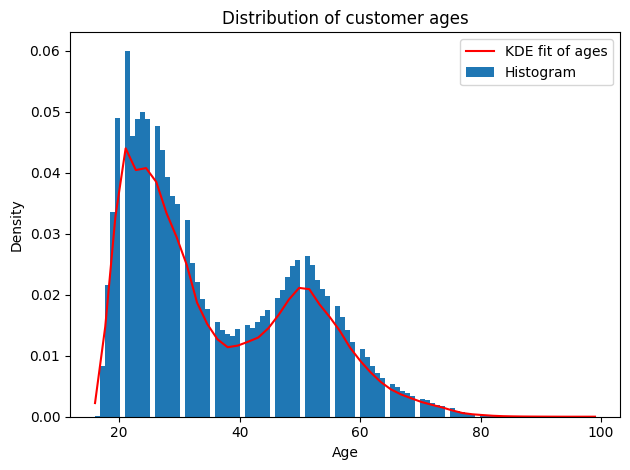

In [16]:
samples = customers_full["age"].dropna()
h, e = np.histogram(samples, bins=100, density=True)
x = np.linspace(e.min(), e.max())

kde_fit = gaussian_kde(samples)
plt.plot(x, kde_fit.pdf(x), "r", label="KDE fit of ages")
plt.xlabel("Age")
plt.ylabel("Density")
plt.bar(e[:-1], h, width=np.diff(e), ec=None, align="edge", label="Histogram")
plt.legend()
plt.title("Distribution of customer ages")
plt.tight_layout()
plt.savefig("figures/distr_ages.pdf")
plt.show()

We see that the ages have a multimodal distribution, where the first peak is for the early 20's and the next peak is around 50.

## Exploring the article data

From the previous output showing the columns in the datasets, we notice that all variables are indexed with a specific ID/group number;

| Index                      | Value                        |
|----------------------------|------------------------------|
| product_code               | prod_name                    |
| product_type_no            | product_type_name            |
|                            | product_group_name           |
| graphical_appearance_no    | graphical_appearance_name    |
| colour_group_code          | colour_group_name            |
| perceived_colour_value_id  | perceived_colour_value_name  |
| perceived_colour_master_id | perceived_colour_master_name |
| department_no              | department_name              |
| index_code                 | index_name                   |
| index_group_no             | index_group_name             |
| section_no                 | section_name                 |
| garment_group_no           | garment_group_name           |

There are also some clear hierarchies within these column types

In [17]:
articles_full.groupby(["index_group_name", "index_name"]).count()["article_id"]

index_group_name  index_name                    
Baby/Children     Baby Sizes 50-98                   8875
                  Children Accessories, Swimwear     4615
                  Children Sizes 134-170             9214
                  Children Sizes 92-140             12007
Divided           Divided                           15149
Ladieswear        Ladies Accessories                 6961
                  Ladieswear                        26001
                  Lingeries/Tights                   6775
Menswear          Menswear                          12553
Sport             Sport                              3392
Name: article_id, dtype: int64

In [18]:
articles_full.groupby(["product_group_name", "product_type_name"]).count()["article_id"]

product_group_name   product_type_name
Accessories          Accessories set         7
                     Alice band              6
                     Baby Bib                3
                     Bag                  1280
                     Beanie                 56
                                          ... 
Underwear            Underwear corset        7
                     Underwear set          47
Underwear/nightwear  Sleep Bag               6
                     Sleeping sack          48
Unknown              Unknown               121
Name: article_id, Length: 132, dtype: int64

In [19]:
# Exploring the article data
for col in (
    "department_name",
    "index_name",
    "index_group_name",
    "section_name",
    "garment_group_name",
):
    print(articles_full.groupby(col).count()["article_id"].sort_values(ascending=False))

department_name
Jersey                             4604
Knitwear                           3503
Trouser                            2655
Blouse                             2362
Dress                              2087
                                   ... 
Accessories Other                     1
Kids Boy License                      1
Jersey inactive from S.6              1
Woven bottoms inactive from S.7       1
Shirt Extended inactive from s1       1
Name: article_id, Length: 250, dtype: int64
index_name
Ladieswear                        26001
Divided                           15149
Menswear                          12553
Children Sizes 92-140             12007
Children Sizes 134-170             9214
Baby Sizes 50-98                   8875
Ladies Accessories                 6961
Lingeries/Tights                   6775
Children Accessories, Swimwear     4615
Sport                              3392
Name: article_id, dtype: int64
index_group_name
Ladieswear       39737
Baby/Children    3

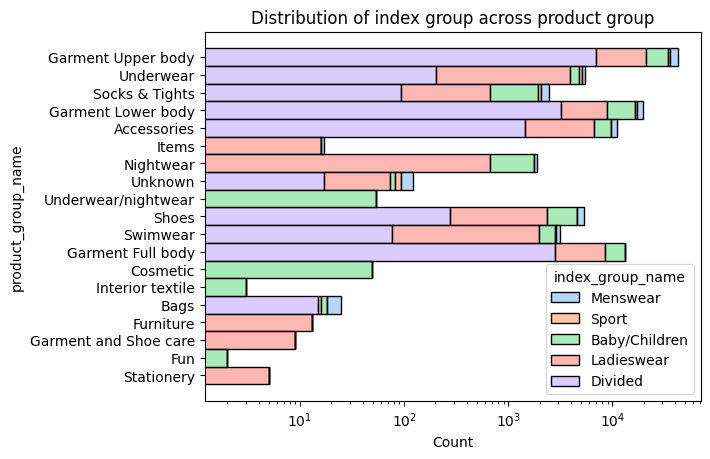

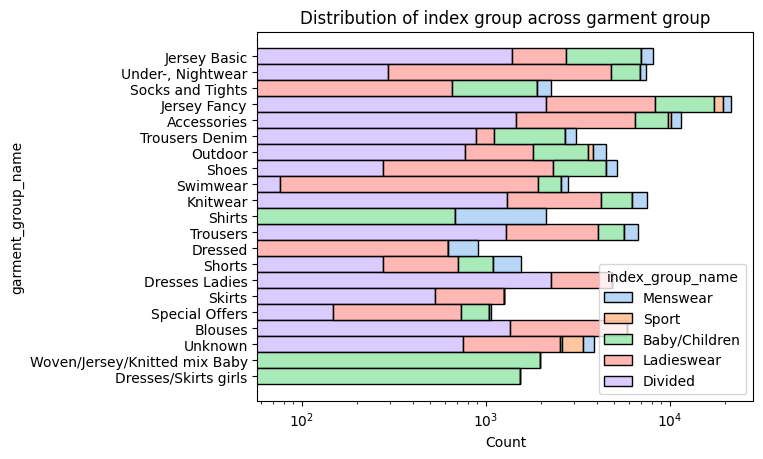

In [20]:
# Let's see how the indicides are spread across
def barplot_articles_on_index(df: pd.DataFrame, y: str):
    import seaborn

    plt.xscale("log")
    plt.title(f"Distribution of index group across {' '.join(y.split('_')[:-1])}")
    seaborn.histplot(
        data=df,
        y=y,
        hue="index_group_name",
        multiple="stack",
        palette="pastel",
        hue_order=["Menswear", "Sport", "Baby/Children", "Ladieswear", "Divided"],
    )
    plt.savefig(f"figures/seaborn_{y}.pdf")
    plt.show()


barplot_articles_on_index(articles_full, "product_group_name")
barplot_articles_on_index(articles_full, "garment_group_name")

Some general oberservations from the bar plots:

Most garment and product groups consists mainly of *Divided* index group, followed by a substatial portion *Ladieswear*. Furhtermore, very few items are assigned as *Sport*, some garment and product groups only contains products for *Baby/Children*, and a couple of garment groups contains only *Ladieswear*.

One last observation is how the corresponding garment groups, index groups and other numbers are spread.

In [24]:
article_id_cols = filter(
    lambda n: n.endswith("_code") or n.endswith("_no") or n.endswith("_id"),
    articles_full.columns,
)
for col in article_id_cols:
    print(col, end="\t")
    print(np.sort(articles_full[col].unique()))

article_id	[108775015 108775044 108775051 ... 956217002 957375001 959461001]
product_code	[108775 110065 111565 ... 956217 957375 959461]
product_type_no	[ -1  49  57  59  60  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  98 100 102 144 155 156 161 196 230 231 245 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 267 268 270 271 272 273 274 275 276 277 283
 284 285 286 287 288 289 291 293 295 296 297 298 299 300 302 303 304 305
 306 307 308 326 349 351 366 389 464 465 467 468 470 475 476 477 483 489
 491 492 493 494 495 496 498 499 503 504 508 509 510 511 512 514 515 521
 523 525 529 532 761 762]
graphical_appearance_no	[     -1 1010001 1010002 1010003 1010004 1010005 1010006 1010007 1010008
 1010009 1010010 1010011 1010012 1010013 1010014 1010015 1010016 1010017
 1010018 1010019 1010020 1010021 1010022 1010023 1010024 1010025 1010026
 1010027 1010028 1010029]
colour_group_code	[-1  1  2  3  4  5  6 

Some of the most interesting findings here, is that a lot of attributes, such as graphical apperance and color has a `-1`, which most likely is used for articles missing information regarding this propterty. We also notice that some of the data starts with 1 as its first ID whereas others start with 1001. This is useful knowledge when constructing the infrastructure of data loading to the model.

## Transactional data

We can look at the number of articles bought for each customer.

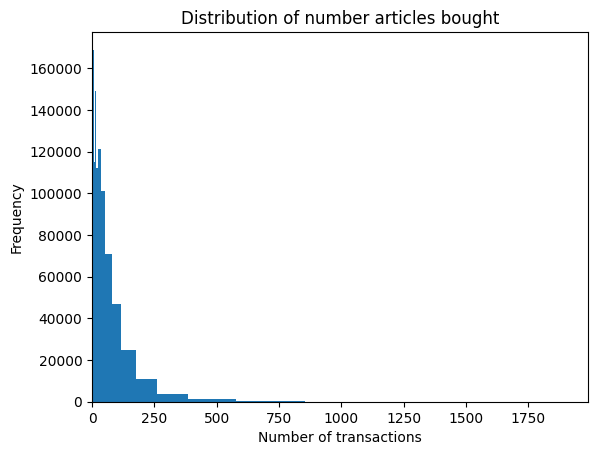

In [21]:
groupbyobj = transactions_full.groupby("customer_id")["article_id"].count()
logbins = np.geomspace(groupbyobj.values.min(), groupbyobj.values.max(), 20)
plt.hist(groupbyobj.values, bins=logbins)
plt.title("Distribution of number articles bought")
plt.ylabel("Frequency")
plt.xlabel("Number of transactions")
plt.xlim(left=0)
plt.savefig("figures/density_articles_bought.pdf")
plt.show()

Here, we look into number of transactions over time

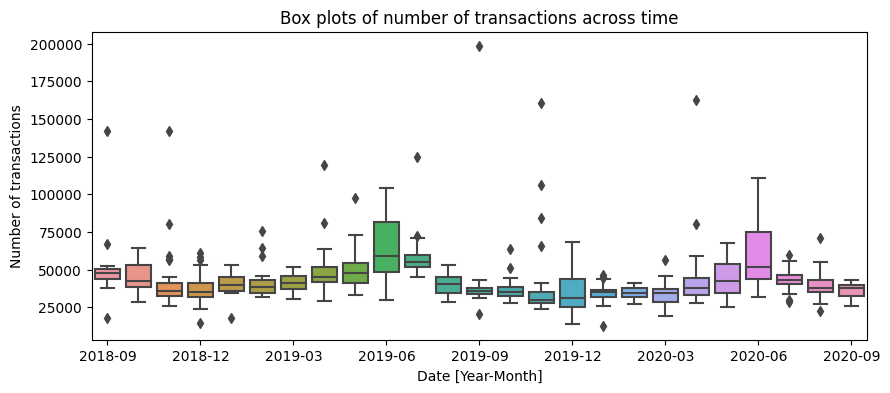

In [22]:
# frequency over time
transactions_full["t_dat"] = pd.to_datetime(transactions_full["t_dat"])
import seaborn as sns

trans_gr_month = transactions_full.groupby("t_dat").size().rename("no_transactions")
trans_gr_month = trans_gr_month.reset_index()
trans_gr_month["month_year"] = trans_gr_month["t_dat"].dt.to_period("M")


fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.boxplot(x="month_year", y="no_transactions", data=trans_gr_month)
# plt.xticks(rotation=90)
plt.locator_params(axis="x", nbins=10)
ax.set_xlabel("Date [Year-Month]")
ax.set_ylabel("Number of transactions")
plt.title("Box plots of number of transactions across time")
plt.savefig("figures/boxplot_transactions.pdf")
plt.show()

There are also some customers who haven't purchased anything in the dataset.

In [23]:
customers_full[~customers_full["customer_id"].isin(transactions_full["customer_id"])]

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
131,00058ecf091cea1bba9d800cabac6ed1ae284202cdab68...,NaN,NaN,ACTIVE,NONE,21.0,1e40bebdc7cbfcb0f0ee995f5e0db13428430874a75c4b...
297,000df4d2084d142416b8165bdd249bab8fea2393447aed...,1.0,1.0,ACTIVE,Regularly,22.0,2c29ae653a9282cce4151bd87643c907644e09541abc28...
544,00193ff7f374dbcfecfa7fead0488e454be4918bec1ebd...,NaN,NaN,ACTIVE,NONE,28.0,0e78861d5ef1caf30cd0c4935cff27657c069c1f2fd2ba...
671,001f00e8c1eba437ff0dbad26a9a3d49e47cbf05fff02a...,1.0,1.0,ACTIVE,Regularly,27.0,d61345e04372ca317ac03dc220889f26a99b4eb20fbf60...
809,002648d8f3b288531b24860f4a68a31d029ec5a0495c04...,1.0,1.0,ACTIVE,Regularly,41.0,4812c1daacee854264500f67aef71d1e713dca9b4755d7...
...,...,...,...,...,...,...,...
1371440,ffe5801cb2a5b51d4d068322d7f8082e995f427a6f22a6...,NaN,NaN,ACTIVE,NONE,55.0,5b8b142d4bb9e28c0d2fc8f87ca22337469f21e7eeb428...
1371554,ffeb3ca867aba57a312fe9d28d67dd46ef2240fe92a94c...,1.0,1.0,ACTIVE,Regularly,21.0,666ea034757d9ac0873fa8f213d7ea359312936e004e99...
1371739,fff456fa60aac9174456c2f36ede5e0f25429a16c88a34...,NaN,NaN,PRE-CREATE,NONE,40.0,efb648f93b15fd00f8a0067791bd47655f6577902b21fc...
1371872,fffa8d3cea26d4f5186472b923629b35fa28051f258030...,1.0,1.0,ACTIVE,Regularly,21.0,c5641c33d0f01f66e69356fdc8ccb3012b14b1f51a90d0...


Since the transactions contain information about the price, we can also look into what articles correspond to the highest purchase prices in the dataset.

In [26]:
groupbyobj = transactions_full.groupby("article_id").agg({"price": list}).reset_index()
most_expensive_idx = (
    groupbyobj["price"].apply(np.max).sort_values(ascending=False).head().index
)
most_expensive_idx

Int64Index([50768, 89491, 37363, 79226, 82848], dtype='int64')

In [28]:
groupbyobj.iloc[most_expensive_idx]["price"].apply(
    max
)  # Get the highest price of artices

50768    0.591525
89491    0.506780
37363    0.506780
79226    0.506780
82848    0.506780
Name: price, dtype: float64

In [29]:
# Product names for the most expensive items
articles_full[
    articles_full["article_id"].isin(groupbyobj.iloc[most_expensive_idx]["article_id"])
][["article_id", "prod_name", "product_type_name"]]

,article_id,prod_name,product_type_name
37399,653551001,Benji leather jacket,Jacket
50826,697511001,PE LINDA LEATHER COAT,Coat
79375,797432001,CEMENT leather jacket,Jacket
83012,810872001,PQ AGDA LEATHER DRESS,Dress
89691,839478001,PQ SUSAN LEATHER TUNIC,Dress
